In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as datetime
import matplotlib.colors as mcolors

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [8]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2010_2015_10min.nc')
#ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2009_2021_10min.nc')
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (dt: 315504, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 3MB 2010-01-01 ... 2015-12-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 3GB ...
    BX_GSE          (dt) float64 3MB ...
    BY_GSE          (dt) float64 3MB ...
    BZ_GSE          (dt) float64 3MB ...
    flow_speed      (dt) float64 3MB ...
    proton_density  (dt) float64 3MB ...

In [9]:
input_scaler = StandardScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

file_path = f'scaler_id3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(input_scaler, file)

def create_sequences(target_data, input_data, lookback=30):
    X, y = [], []
    for i in range(len(target_data) - lookback):
        X.append(input_data[i:i+lookback].T)
        y.append(target_data[i+lookback])

    return np.array(X), np.array(y)

lookback = 6
X, y = create_sequences(target_var, input_data_scaled, lookback=lookback)
X.shape, y.shape

((315498, 5, 6), (315498, 50, 24))

In [10]:
def simple_time_series_split(X, y, train_ratio=0.9, test_ratio=0.09):

    # Calculate split indices
    train_idx = int(len(X) * train_ratio)
    test_idx = int(len(X) * (train_ratio + test_ratio))

    # Perform the split
    X_train, X_val, X_test = X[:train_idx], X[train_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:train_idx], y[train_idx:test_idx], y[test_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = simple_time_series_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((283948, 5, 6), (28395, 5, 6), (3155, 5, 6))

In [11]:
# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = np.array(y_test)

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_train.shape, y_train.shape

(torch.Size([283948, 5, 6]), torch.Size([283948, 50, 24]))

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        out = F.relu(out)

        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(64)
        
        self.resblock1 = ResidualBlock(64, 64)
        self.resblock2 = ResidualBlock(64, 64)
        self.resblock3 = ResidualBlock(64, 64)
        
        self.fc1 = nn.Linear(5 * 6 * 64, 1200)
        self.fc2 = nn.Linear(1200, 50 * 24)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Adding a channel dimension (assuming grayscale image input)
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 50, 24)  # Reshape to 50x24 map
        
        return x

# Example usage
model = CNN()
model.to(device)


CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn

In [13]:
loss_function = nn.L1Loss() #AKA MAE
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=25, gamma=0.7)

In [14]:
#Train the model
num_epochs = 20
train_losses = []
val_losses = []

# Early stopping
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        train_outputs = model(X_batch)
        loss = loss_function(train_outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss += loss_function(val_outputs, y_batch).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_kunduri_model.pt')
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
            break
        else:
            continue

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss (MAE): {train_loss:.4f}, Val Loss (MAE): {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.1e}')

   
best_model = CNN()
best_model.load_state_dict(torch.load('best_kunduri_model.pt'))
best_model.to(device)

Epoch [1/20], Train Loss (MAE): 0.0916, Val Loss (MAE): 0.1049, Best Val Loss: 0.1049, LR: 1.0e-05
Epoch [2/20], Train Loss (MAE): 0.0855, Val Loss (MAE): 0.1038, Best Val Loss: 0.1038, LR: 1.0e-05
Epoch [3/20], Train Loss (MAE): 0.0849, Val Loss (MAE): 0.1033, Best Val Loss: 0.1033, LR: 1.0e-05
Epoch [4/20], Train Loss (MAE): 0.0843, Val Loss (MAE): 0.1020, Best Val Loss: 0.1020, LR: 1.0e-05
Epoch [5/20], Train Loss (MAE): 0.0834, Val Loss (MAE): 0.1012, Best Val Loss: 0.1012, LR: 1.0e-05
Epoch [6/20], Train Loss (MAE): 0.0829, Val Loss (MAE): 0.1009, Best Val Loss: 0.1009, LR: 1.0e-05
Epoch [7/20], Train Loss (MAE): 0.0826, Val Loss (MAE): 0.1006, Best Val Loss: 0.1006, LR: 1.0e-05
Epoch [8/20], Train Loss (MAE): 0.0824, Val Loss (MAE): 0.1005, Best Val Loss: 0.1005, LR: 1.0e-05
Epoch [9/20], Train Loss (MAE): 0.0823, Val Loss (MAE): 0.1003, Best Val Loss: 0.1003, LR: 1.0e-05
Epoch [10/20], Train Loss (MAE): 0.0822, Val Loss (MAE): 0.1002, Best Val Loss: 0.1002, LR: 1.0e-05
Epoch [11

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn

In [15]:
with torch.no_grad():
     predictions = best_model(X_test).cpu().numpy()


In [16]:
RMSE = np.sqrt(np.mean((y_test - predictions)**2))
NRMSE = RMSE / np.std(y_test)
MAE = np.mean(np.abs(y_test - predictions))
R = np.corrcoef(y_test.flatten(), predictions.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill      

PE = skill(predictions, y_test)

print(f'Test Loss (RMSE): {RMSE:.4f}, Test Loss (NRMSE): {NRMSE:.4f}, Test Loss (MAE): {MAE:.4f}, R: {R:.4f}, Skill: {PE:.4f}')

Test Loss (RMSE): 0.1510, Test Loss (NRMSE): 0.9562, Test Loss (MAE): 0.0923, R: 0.3103, Skill: 0.0856


In [17]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='dt', combine='nested', parallel=True)
    ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
    ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)

    #average over 5min
    ds = ds.resample(dt='10min').mean()
    #ds = ds.interpolate_na(dim='dt')

    #ds = ds.sel(nRec=slice(16500, 17000))

    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/excluded/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp

<xarray.Dataset> Size: 1MB
Dimensions:         (mlat: 50, mlt: 24, dt: 144)
Coordinates:
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
  * dt              (dt) datetime64[ns] 1kB 2013-05-14 ... 2013-05-14T23:50:00
Data variables: (12/15)
    jPar            (dt, mlat, mlt) float64 1MB dask.array<chunksize=(1, 50, 24), meta=np.ndarray>
    BX_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    BY_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    BZ_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    flow_speed      (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    proton_density  (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...              ...
    ASY_H           (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    F10.7           (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    Kp              (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy             (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy_sin         (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy_cos         (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>

In [18]:
def split_to_df(ds):
    ds = ds.copy()

    dt = ds['dt'].values.flatten()
    BX_GSE = ds['BX_GSE'].values.flatten() #1
    BY_GSE = ds['BY_GSE'].values.flatten() #2
    BZ_GSE = ds['BZ_GSE'].values.flatten() #3
    flow_speed = ds['flow_speed'].values.flatten() #4
    proton_density = ds['proton_density'].values.flatten() #5
    doy_sin = ds['doy_sin'].values.flatten() #6
    doy_cos = ds['doy_cos'].values.flatten() #7
    
    #AL_INDEX = ds['AL_INDEX'].values.flatten() #6
    #AU_INDEX = ds['AU_INDEX'].values.flatten() #7
    #SYM_H = ds['SYM_H'].values.flatten() #8
    #ASY_H = ds['ASY_H'].values.flatten()  #9
    F10_7 = ds['F10.7'].values.flatten() #10
    #Kp = ds['Kp'].values.flatten() #11

    #return BX_GSE.shape

    df_dict = {'dt':dt, 'BX_GSE': BX_GSE, 'BY_GSE': BY_GSE, 'BZ_GSE': BZ_GSE, 'flow_speed': flow_speed, 'proton_density': proton_density}
    df = pd.DataFrame(df_dict)
    
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])

    return df, df_2

split_to_df(open_multi_amp)
df_raw, df_proc = split_to_df(open_multi_amp)
col_names = df_raw.columns

In [19]:
norm_arr = input_scaler.transform(df_proc)

def create_sequences(arr, lookback=lookback):
    X = []
    for i in range(len(arr) - lookback):
        X.append(arr[i:i+lookback].T)

    X = np.array(X)

    return X

proc_seq = create_sequences(norm_arr)
raw_seq = create_sequences(df_raw.values)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [20]:
# Assuming best_model is already defined and loaded
device = torch.device('cpu')
best_model.to(device)  # Ensure the model is on the CPU
best_model.eval()

# Adjust the shape to match the model's expected input size
norm_proc = torch.tensor(proc_seq, dtype=torch.float32).to(device)
norm_proc = norm_proc.permute(0, 1, 2)  # Change from [848370, 11, 30] to [848370, 30, 11]

predictions = []

with torch.no_grad():
    for i in range(len(norm_proc)):
        output = best_model(norm_proc[i].unsqueeze(0))
        predictions.append(output)

predictions = torch.cat(predictions)
predictions = predictions.numpy()  # Tensor is already on CPU, no need to move again

In [21]:
ds = xr.Dataset({'Jpar_pred': (['dt', 'mlat', 'mlt'], predictions),
                 'Jpar_true': (['dt', 'mlat', 'mlt'], open_multi_amp['jPar'].values[lookback:]),
                 'BX_GSE': (['dt'], open_multi_amp['BX_GSE'].values[lookback:]),
                  'BY_GSE': (['dt'], open_multi_amp['BY_GSE'].values[lookback:]),
                    'BZ_GSE': (['dt'], open_multi_amp['BZ_GSE'].values[lookback:]),
                    'flow_speed': (['dt'], open_multi_amp['flow_speed'].values[lookback:]),
                    'proton_density': (['dt'], open_multi_amp['proton_density'].values[lookback:]),
                 },
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
ds

<xarray.Dataset> Size: 2MB
Dimensions:         (dt: 138, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 1kB 2013-05-14T01:00:00 ... 2013-05-1...
  * mlat            (mlat) int64 400B 40 41 42 43 44 45 46 ... 84 85 86 87 88 89
  * mlt             (mlt) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred       (dt, mlat, mlt) float32 662kB -0.003439 ... -0.001289
    Jpar_true       (dt, mlat, mlt) float64 1MB 0.104 -0.09871 ... -0.05456
    BX_GSE          (dt) float64 1kB 3.258 1.508 2.345 ... -4.794 -5.127 -6.225
    BY_GSE          (dt) float64 1kB 0.708 -3.454 -2.594 ... 3.589 2.616 2.583
    BZ_GSE          (dt) float64 1kB 2.251 1.013 1.63 1.9 ... 5.501 6.371 5.538
    flow_speed      (dt) float64 1kB 370.4 361.0 365.2 ... 334.6 337.0 334.0
    proton_density  (dt) float64 1kB 8.861 8.996 9.149 ... 12.1 11.11 10.02

In [22]:
timestep = 83

R = np.corrcoef(ds['Jpar_pred'].isel(dt=timestep).values, ds['Jpar_true'].isel(dt=timestep).values)[1,0]
RMSE = np.sqrt(np.mean((ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values)**2))
MAE = np.mean(np.abs(ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values))
NRMSE = RMSE / (np.max(ds['Jpar_true'].isel(dt=timestep).values) - np.min(ds['Jpar_true'].isel(dt=timestep).values))

print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')
ds.isel(dt=timestep)

R: 0.143, RMSE: 0.208, NRMSE: 0.101, MAE: 0.122


<xarray.Dataset> Size: 15kB
Dimensions:         (mlat: 50, mlt: 24)
Coordinates:
    dt              datetime64[ns] 8B 2013-05-14T14:50:00
  * mlat            (mlat) int64 400B 40 41 42 43 44 45 46 ... 84 85 86 87 88 89
  * mlt             (mlt) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred       (mlat, mlt) float32 5kB 0.002555 0.0002814 ... -0.001312
    Jpar_true       (mlat, mlt) float64 10kB 0.09609 0.1743 ... -0.02152 0.06192
    BX_GSE          float64 8B -6.053
    BY_GSE          float64 8B 3.81
    BZ_GSE          float64 8B -3.813
    flow_speed      float64 8B 376.0
    proton_density  float64 8B 5.729

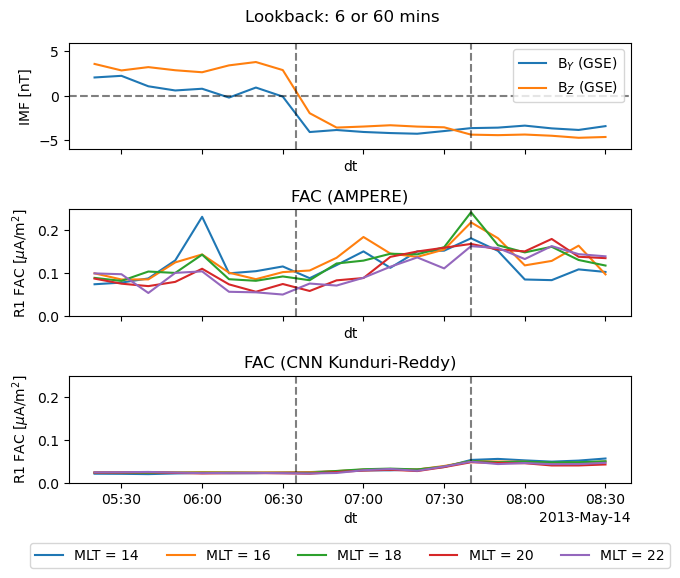

In [24]:
#linepllot of Jpat true across all mlat and mlt at a given timestep with dt as x-axis

def plot_line(ds):
    ds = ds.copy()

    fig, ax = plt.subplots(3,1,figsize=(7, 6), sharex=True, sharey=False)
    ds = ds.sel(dt=slice('2013-05-14T05:15:00', '2013-05-14T08:30:00'))
    ds = ds.sel(mlt=slice(14,23))
    ds = ds.sel(mlat=slice(65,78))

    ds['Jpar_true_abs'] = np.abs(ds['Jpar_true'])
    ds['Jpar_pred_abs'] = np.abs(ds['Jpar_pred'])

    ds['BY_GSE'].plot(ax=ax[0], label='BY_GSE')
    ds['BZ_GSE'].plot(ax=ax[0], label='BZ_GSE')
    ax[0].legend(loc='upper right')
    ax[0].set_ylim(-6, 6)
    ax[0].set_ylabel(f'IMF [nT]')
    #change labels in legend
    ax[0].legend(['B$_{Y}$ (GSE)', 'B$_{Z}$ (GSE)'])


    ds['Jpar_true_abs'].isel(mlt=0).mean(dim='mlat').plot(ax=ax[1], label='MLT = 14')
    ds['Jpar_true_abs'].isel(mlt=2).mean(dim='mlat').plot(ax=ax[1], label='MLT = 16')
    ds['Jpar_true_abs'].isel(mlt=4).mean(dim='mlat').plot(ax=ax[1], label='MLT = 18')
    ds['Jpar_true_abs'].isel(mlt=6).mean(dim='mlat').plot(ax=ax[1], label='MLT = 20')
    ds['Jpar_true_abs'].isel(mlt=8).mean(dim='mlat').plot(ax=ax[1], label='MLT = 22')
    ax[1].set_title('FAC (AMPERE)')
    fac_units = r'$\mu$A/m$^2$'
    ax[1].set_ylabel(f'R1 FAC [{fac_units}]')
    ax[1].set_ylim(0, 0.25)

    ds['Jpar_pred_abs'].isel(mlt=0).mean(dim='mlat').plot(ax=ax[2], label='MLT = 14')
    ds['Jpar_pred_abs'].isel(mlt=2).mean(dim='mlat').plot(ax=ax[2], label='MLT = 16')
    ds['Jpar_pred_abs'].isel(mlt=4).mean(dim='mlat').plot(ax=ax[2], label='MLT = 18')
    ds['Jpar_pred_abs'].isel(mlt=6).mean(dim='mlat').plot(ax=ax[2], label='MLT = 20')
    ds['Jpar_pred_abs'].isel(mlt=8).mean(dim='mlat').plot(ax=ax[2], label='MLT = 22')
    ax[2].set_title('FAC (CNN Kunduri-Reddy)')
    ax[2].set_ylabel(f'R1 FAC [{fac_units}]')
    ax[2].set_ylim(0, 0.25)

    fig.suptitle(f'Lookback: 6 or 60 mins ', linespacing=1.5)    

    #add vertcal bar to all suplots at 6:00
    for i in range(3):
        ax[i].axvline(x=datetime.datetime(2013, 5, 14, 6, 35, 0), color='black', linestyle='--', alpha=0.5)

    for i in range(3):
        ax[i].axvline(x=datetime.datetime(2013, 5, 14, 7, 40, 0), color='black', linestyle='--', alpha=0.5)

    #add horiztonal line at y = 0 for subplot0
    ax[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    legend = ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), shadow=False, ncol=5)
    plt.tight_layout()
    #ax[0].grid()
    #ax[1].grid()
    #ax[2].grid()

    plt.savefig('Lookback_60_mins_kunduri.png', dpi=300)

plot_line(ds)

<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_54611/3320102447.py:39: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


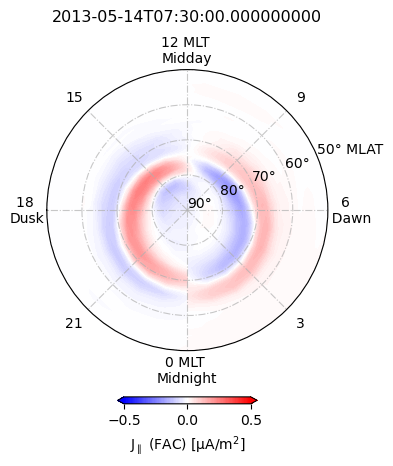

In [31]:
timestep=39
fac = ds['Jpar_pred'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.45, .45, 100), extend='both')
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0, 0.5], 
             orientation='horizontal')

#plt.tight_layout()
plt.savefig('Lookback_60_mins_kundari_polar_prediction.png', dpi=300, bbox_inches='tight')